In [4]:
import os
import sqlite3
import tempfile
import json
import requests
from fake_useragent import UserAgent
from openai import OpenAI
import moviepy.editor as mp
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.schema import Document

DATABASE_PATH = '/Users/mins/Desktop/github/bilibili_summarize/db/sqlite/bilibili.db'
BASE_URL = '/Users/mins/Desktop/github/bilibili_summarize/static'
COOKIE_PATH = '/Users/mins/Desktop/github/bilibili_summarize/cookie/cookie.json'

class DyanmicTools:
    def video_2_audio(self, id: str):
        try:
            videos_path = os.path.join(BASE_URL, 'video', f"{id}.mp4")
            audio_path = os.path.join(BASE_URL, 'audio', f"{id}.mp3")

            conn = sqlite3.connect(DATABASE_PATH)
            cursor = conn.cursor()

            cursor.execute("SELECT COUNT(*) FROM dynamic WHERE id = ?", (id,))
            exists = cursor.fetchone()[0]

            my_clip = mp.VideoFileClip(videos_path)
            my_clip.audio.write_audiofile(audio_path)

            with open(audio_path, 'rb') as audio_file:
                audio_bytes = audio_file.read()

            if exists:
                cursor.execute("UPDATE dynamic SET audio = ? WHERE id = ?", (audio_bytes, id))
            else:
                cursor.execute("INSERT INTO dynamic (id, audio) VALUES (?, ?)", (id, audio_bytes))

            conn.commit()
            conn.close()
        except FileNotFoundError as e:
            raise FileNotFoundError(f"文件未找到: {e}")
        except Exception as e:
            raise Exception(f"发生错误: {e}")

    def audio_2_content(self, id: str):
        if not id:
            raise ValueError("id 未提供")

        client = OpenAI()

        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        cursor.execute("SELECT audio FROM dynamic WHERE id = ?", (id,))
        audio_data = cursor.fetchone()

        if audio_data is None:
            raise ValueError("未找到音频数据")

        temp_audio_file_path = None
        try:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as temp_audio_file:
                temp_audio_file.write(audio_data[0])
                temp_audio_file_path = temp_audio_file.name

            with open(temp_audio_file_path, "rb") as audio_file:
                transcript = client.audio.transcriptions.create(
                    model="whisper-1",
                    file=audio_file,
                    response_format="json"
                )
            print(transcript)
            content = transcript.text

            cursor.execute("UPDATE dynamic SET content = ? WHERE id = ?", (content, id))
            conn.commit()
        except Exception as e:
            raise Exception(f"OpenAI API 错误: {e}")
        finally:
            if temp_audio_file_path:
                os.remove(temp_audio_file_path)
            conn.close()

    def content_2_summary(self, id: str):
        if not id:
            raise ValueError("id 未提供")

        try:
            prompt_template = """
            Write a concise summary of the following:
            "{text}"
            CONCISE SUMMARY，请用简体中文回答:
            """
            prompt = PromptTemplate.from_template(prompt_template)

            llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
            llm_chain = LLMChain(llm=llm, prompt=prompt)
            stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

            conn = sqlite3.connect(DATABASE_PATH)
            cursor = conn.cursor()
            cursor.execute("SELECT content FROM dynamic WHERE id = ?", (id,))
            text = cursor.fetchone()

            if text is None:
                raise ValueError("未找到文本数据")

            documents = [Document(page_content=text[0])]
            summary = stuff_chain.invoke(documents)["output_text"]
            print(summary)
            cursor.execute("UPDATE dynamic SET summary = ? WHERE id = ?", (summary, id))
            conn.commit()
        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found error: {e}")
        except IOError as e:
            raise IOError(f"IO error: {e}")
        except Exception as e:
            raise Exception(f"发生错误: {e}")
        finally:
            conn.close()

    def sent_bilibili_dynamic(self, id: str):
        if not id:
            raise ValueError("id 未提供")

        try:
            with open(COOKIE_PATH, 'r') as file:
                cookie = dict(json.load(file))
        except FileNotFoundError:
            raise FileNotFoundError("未查询到用户文件，请确认资源完整")
        except json.JSONDecodeError:
            raise ValueError("用户文件格式错误")

        ua = UserAgent()
        url = "https://api.vc.bilibili.com/dynamic_svr/v1/dynamic_svr/create"
        headers = {
            "Content-Type": "application/x-www-form-urlencoded",
            "User-Agent": ua.random,
            "Cookie": "; ".join([f"{key}={value}" for key, value in cookie.items()])
        }

        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        cursor.execute("SELECT summary FROM dynamic WHERE id = ?", (id,))
        summary = cursor.fetchone()[0]
        print(summary)
        content = f"https://www.bilibili.com/video/{id}\n{summary}"
        data = {
            "type": 4,
            "rid": 0,
            "content": content
        }

        try:
            response = requests.post(url, headers=headers, data=data)
            response.raise_for_status()
            cursor.execute("UPDATE dynamic SET is_sent = ? WHERE id = ?", (1, id))
            conn.commit()
        except requests.RequestException as e:
            raise Exception(f"动态发布失败，错误信息: {str(e)}")
        except Exception as e:
            raise Exception(f"发生错误: {e}")
        finally:
            conn.close()

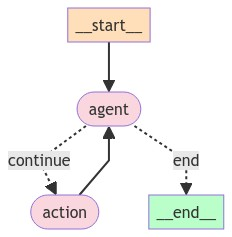

last_message: content='' additional_kwargs={'tool_calls': [{'id': 'call_bPZqwkD3dBYZf9TtLJBQVfPG', 'function': {'arguments': '{"id": "BV1AS421N7Rc"}', 'name': 'video_2_audio_tool'}, 'type': 'function'}, {'id': 'call_IYZdMAC93aBicP2dajiijqHl', 'function': {'arguments': '{"id": "BV1AS421N7Rc"}', 'name': 'audio_2_content_tool'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 304, 'total_tokens': 366}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-087d92a6-011d-4599-b10d-aaba7c7802df-0' tool_calls=[{'name': 'video_2_audio_tool', 'args': {'id': 'BV1AS421N7Rc'}, 'id': 'call_bPZqwkD3dBYZf9TtLJBQVfPG'}, {'name': 'audio_2_content_tool', 'args': {'id': 'BV1AS421N7Rc'}, 'id': 'call_IYZdMAC93aBicP2dajiijqHl'}] usage_metadata={'input_tokens': 304, 'output_tokens': 62, 'total_tokens': 366}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 

MoviePy - Done.
{'action': {'messages': [ToolMessage(content="{'id': 'BV1AS421N7Rc'}", name='video_2_audio_tool', tool_call_id='call_bPZqwkD3dBYZf9TtLJBQVfPG')]}}
----


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_IYZdMAC93aBicP2dajiijqHl", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

In [22]:

# https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/?h=workflow+add+node+agent#build-the-agent

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.prebuilt import ToolExecutor

from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import ToolMessage


processor = DyanmicTools()

# class State(TypedDict):
#     id: str
#     video: str
#     audio: str
#     content: str
#     summary: str
#     dynamic: bool
#     is_last_step: bool


@tool
def video_2_audio_tool(id: str):
    """
    Convert a video to its corresponding audio by its bvid.

    Args:
        id (str): The ID of the video to convert to audio.

    Returns:
        str: The ID of the video that was successfully converted to audio.
    """
    processor.video_2_audio(id)
    return {"id": id}

@tool
def audio_2_content_tool(id: str):
    """
    Convert a audio to its corresponding content by its bvid.

    Args:
        id (str): The ID of the audio to convert to content.

    Returns:
        str: The ID of the audio that was successfully converted to content.
    """
    processor.audio_2_content(id)
    return {"id": id}

@tool
def content_2_summary_tool(id: str):
    """
    Summarize content by its ID.

    Args:
        id (str): The ID of the content to summarize.

    Returns:
        str: The summary of the content that was successfully generated.
    """
    processor.content_2_summary(id)
    return {"id": id}

@tool
def sent_bilibili_dynamic_tool(id: str):
    """
    Summarize content by its ID and post the summary to Bilibili's dynamic.

    Args:
        id (str): The ID of the content to summarize.

    Returns:
        str: A message indicating whether the summary was successfully posted to Bilibili's dynamic.
    """
    processor.sent_bilibili_dynamic(id)
    return {"id": id}

tools = [video_2_audio_tool, audio_2_content_tool, content_2_summary_tool, sent_bilibili_dynamic_tool]
tool_executor = ToolExecutor(tools)

model = ChatOpenAI(model = 'gpt-4o')
model = model.bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    print("last_message:", last_message)
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a ToolMessage
    tool_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [tool_message]}


from langgraph.graph import END, StateGraph
workflow = StateGraph(MessagesState)


# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)
workflow.add_edge("action", "agent")

graph = workflow.compile()


from IPython.display import Image, display
# 画出工作流图
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


from langchain_core.messages import HumanMessage

input = {"messages": [HumanMessage(content="请将视频（id：BV1AS421N7Rc）下载为音频，音频转为文本，再对文本进行摘要，并发送到bilibili动态")]}

# input = {
#     "id":"BV1AS421N7Rc",
#     "video": "未完成",
#     "audio": "未完成",
#     "content": "未完成",
#     "summary": "未完成",
#     "dynamic": False,
# }
# 执行工作流图，流式输出
events = graph.stream(input)
for s in events:
    print(s)
    print("----")